<a href="https://colab.research.google.com/github/BlackSparrow-43/deep-rl-class/blob/main/My_Projects/Q-Learning/Taxi/Taxi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym[all] -q

import numpy as np
import gym
import random
import time
from tqdm.notebook import tqdm

     |████████████████████████████████| 1.6 MB 4.1 MB/s 
     |████████████████████████████████| 3.7 MB 38.5 MB/s 
     |████████████████████████████████| 3.5 MB 37.4 MB/s 
     |████████████████████████████████| 1.2 MB 56.4 MB/s 
     |████████████████████████████████| 18.3 MB 100 kB/s 
     |████████████████████████████████| 296 kB 70.6 MB/s 
     |████████████████████████████████| 2.4 MB 51.1 MB/s 
     |████████████████████████████████| 2.1 MB 45.4 MB/s 
     |████████████████████████████████| 3.4 MB 34.1 MB/s 
     |████████████████████████████████| 207 kB 46.7 MB/s 
     |████████████████████████████████| 3.1 MB 40.8 MB/s 


In [2]:
!pip install pyvirtualdisplay -q
!apt install xvfb -y -q 

import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython import display

%matplotlib inline
Display().start()

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 785 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.11 [785 kB]
Fetched 785 kB in 1s (917 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155569 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.11_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.11) ...
Setting up xvfb (2:1.19.6-1ubuntu4.11) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
def show_render_1(env):
  plt.figure(3,figsize=(27,9))
  plt.imshow(env.render(mode='rgb_array'))
  display.display(plt.gcf())
  display.clear_output(wait=True)

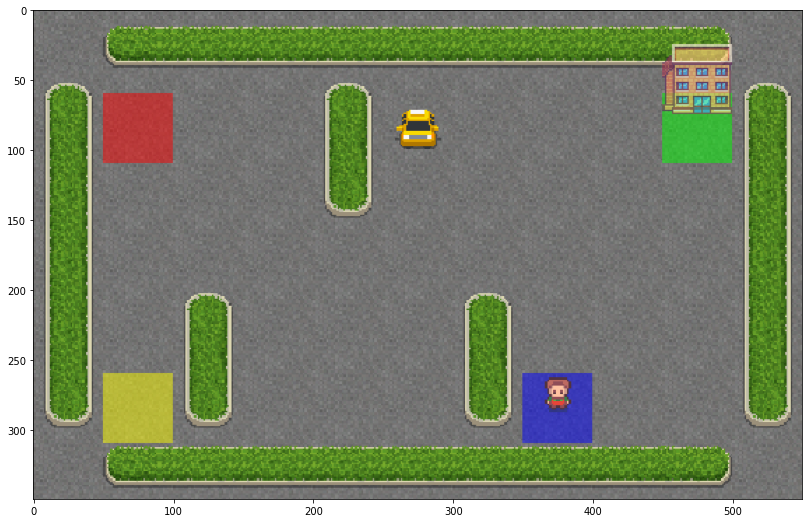

In [4]:
env = gym.make("Taxi-v3")
env.reset()
show_render_1(env)

In [5]:
state_space = env.observation_space.n
action_space = env.action_space.n
q_table = np.zeros((state_space,action_space))
(state_space,action_space)

(500, 6)

In [6]:
epsilon = 1.
max_epsilon = 1.
min_epsilon = .01
decay_rate = .0005

total_episodes = 30000
each_episode_steps = 1000
learning_rate = 0.8
discount_rate = 0.95
log_interval = 1000

In [7]:
def epsilon_greedy_policy(epsilon,state,q_table):
  if random.uniform(0,1) > epsilon:
    action = np.argmax(q_table[state])
    select="table"
  else:
    action = env.action_space.sample()
    select = "random"
  return action, select

In [8]:
def epsilon_reduce(epsiode):
  return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epsiode)

In [9]:
def greedy_policy(state,q_table):
  return np.max(q_table[state])

In [10]:
def new_reward(reward, state, done, action):
  
  obs = []
  obs.append(state % 4)
  state = state // 4
  obs.append(state % 5)
  state = state // 5
  obs.append(state % 5)
  state = state // 5
  obs.append(state)
  assert 0 <= state < 5

  taxi_rows, taxi_cols, pas_loc, pas_dest = reversed(obs)

  locs = {0:(0, 0), 
          1:(0, 4), 
          2:(4, 0), 
          3:(4, 3),
          4:"in_taxi"}
  reward_drop, reward_pickup, reward_step = 0, 0, 0

  if action == 5: 
    if locs[pas_dest] == (taxi_rows, taxi_cols) and done:
      reward_drop = 100
    else:
      reward_drop = -20
  elif action == 4:
    if locs[pas_loc] == (taxi_rows, taxi_cols):
      reward_pickup = 50
    else:
      reward_pickup = -20
      
  if action < 4:
    if locs[4] == locs[pas_loc]:
      reward_step = -2
    else:
      reward_step = -4

  return reward_drop + reward_pickup + reward_step

In [11]:
def train():
  table_nos, random_nos, total_rewards, episode_reward = 0, 0, 0, 0
  for episode in range(total_episodes):
    state = env.reset()
    step = 0
    done = False
    step_reward = 0
    epsilon = epsilon_reduce(episode)
    for step in range(each_episode_steps):
      action, select = epsilon_greedy_policy(epsilon, state, q_table)
      new_state, reward, done, info = env.step(action)
      rewards = new_reward(reward, new_state, done, action)
      error = learning_rate*(rewards + discount_rate*(greedy_policy(new_state, q_table)) - q_table[state][action])
      q_table[state][action] = q_table[state][action] + error
      step_reward += rewards
      if done:
        break
      state = new_state
      if select == "table":
        table_nos += 1
      elif select == "random":
        random_nos += 1
    episode_reward += step_reward
    if episode % log_interval == 0:
      table_per = round((table_nos/(table_nos+random_nos))*100,2)
      random_per = round((random_nos/(table_nos+random_nos))*100,2)
      total_rewards += episode_reward
      print("Gen="+str(episode),"random="+str(random_per),"table="+str(table_per),"steps_taken="+str(step),"mean_reward="+str(episode_reward/1000),"episode_reward="+str(episode_reward),"total_reward="+str(total_rewards)) 
      episode_reward = 0
  env.close()
  print("Gen="+str(episode),"random="+str(random_per),"table="+str(table_per),"steps_taken="+str(step),"mean_reward="+str(episode_reward/1000),"episode_reward="+str(episode_reward),"total_reward="+str(total_rewards)) 
  return q_table

In [12]:
def play(q_table):
  state = env.reset()
  done = False
  rewards =0
  for step in range(each_episode_steps):
    time.sleep(1)
    show_render_1(env)
    action = np.argmax(q_table[state])
    new_state, reward, done, info = env.step(action)
    rewards += new_reward(reward, new_state, done, action)
    state = new_state
    if done:
      break
  show_render_1(env)
  print("#############steps_taken="+str(step),"reward="+str(rewards)+"###############")
  env.close()

In [13]:
#q_table = np.load("taxi.npy")

In [14]:
q_table_frozenlake = train()

Gen=0 random=100.0 table=0.0 steps_taken=199 mean_reward=-1.776 episode_reward=-1776 total_reward=-1776
Gen=1000 random=85.17 table=14.83 steps_taken=24 mean_reward=-777.188 episode_reward=-777188 total_reward=-778964
Gen=2000 random=77.95 table=22.05 steps_taken=16 mean_reward=-74.1 episode_reward=-74100 total_reward=-853064
Gen=3000 random=72.15 table=27.85 steps_taken=29 mean_reward=-0.742 episode_reward=-742 total_reward=-853806
Gen=4000 random=67.24 table=32.76 steps_taken=10 mean_reward=22.528 episode_reward=22528 total_reward=-831278
Gen=5000 random=62.99 table=37.01 steps_taken=19 mean_reward=34.13 episode_reward=34130 total_reward=-797148
Gen=6000 random=59.19 table=40.81 steps_taken=12 mean_reward=38.796 episode_reward=38796 total_reward=-758352
Gen=7000 random=55.82 table=44.18 steps_taken=12 mean_reward=42.732 episode_reward=42732 total_reward=-715620
Gen=8000 random=52.84 table=47.16 steps_taken=14 mean_reward=45.532 episode_reward=45532 total_reward=-670088
Gen=9000 rando

#############steps_taken=15 reward=40###############


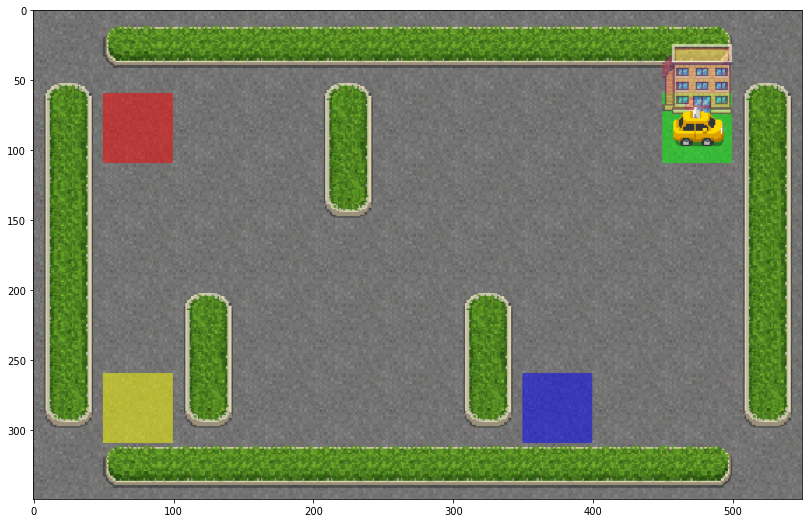

In [15]:
play(q_table_frozenlake)

In [16]:
#np.save("taxi.npy",q_table)

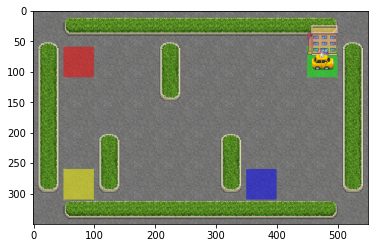

In [17]:
img = plt.imshow(env.render('rgb_array'))
def show_render_2(env):
  img.set_data(env.render('rgb_array')) 
  display.display(plt.gcf())
  display.clear_output(wait=True)

In [ ]:
!apt-get install python-opengl -y
!pip install piglet